In [1]:
path = '/content/drive/MyDrive/Colab Notebooks/test/**stats/DeepLearning/Practice_folder/TimeSeries/UCIForecast/RoomOccupancy/Occupancy_Estimation.csv'

In [2]:
!pip install mlforecast
!pip install scikit-optimize
!pip install statsforecast
!pip install catboost
!pip install neuralforecast
!pip install nixtlats
!pip install fugue
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 886.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 7.7 MB/s eta 0:00:00
  Created wheel for fugue-sql-antlr: filename=fugue_sql_antlr-0.2.0-py3-none-any.whl size=158196 sha256=db6640463d8de9ee37ee23df3f86f02bcc71779e25641d8dc8c78b863e47f45f
  Stored in directory: /root/.cache/pip/wheels/5a/b5/4

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import periodogram
from scipy import stats

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import MSTL
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.tsa.stattools import pacf, acf

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression, Lasso, Ridge, HuberRegressor, TheilSenRegressor, SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import RandomForestRegressor, StackingRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingClassifier
from sklearn.multioutput import RegressorChain

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from utilsforecast.plotting import plot_series
from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate

from statsforecast import StatsForecast
from statsforecast.models import IMAPA, MSTL, AutoARIMA
from statsforecast.utils import ConformalIntervals

from mlforecast.target_transforms import Differences
from mlforecast.core import TimeSeries
from mlforecast.utils import PredictionIntervals
from mlforecast import MLForecast

from neuralforecast.auto import AutoNHITS
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.models import TimesNet

from nixtlats import TimeGPT
from ray import tune

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

import gc
import torch



pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(10, 8))
plt.rc("font", size=10)

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Preprocess data

## Import data and look around

In [4]:
df = pd.read_csv(path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

In [ ]:
df.isna().sum()/len(df)

Date                    0.0
Time                    0.0
S1_Temp                 0.0
S2_Temp                 0.0
S3_Temp                 0.0
S4_Temp                 0.0
S1_Light                0.0
S2_Light                0.0
S3_Light                0.0
S4_Light                0.0
S1_Sound                0.0
S2_Sound                0.0
S3_Sound                0.0
S4_Sound                0.0
S5_CO2                  0.0
S5_CO2_Slope            0.0
S6_PIR                  0.0
S7_PIR                  0.0
Room_Occupancy_Count    0.0
dtype: float64

In [ ]:
df.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [ ]:
df.describe()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.00000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,25.454012,25.546059,25.056621,25.754125,25.445059,26.01629,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,-0.004830,0.090137,0.079574,0.398559
std,0.351351,0.586325,0.427283,0.356434,51.011264,67.30417,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,1.164990,0.286392,0.270645,0.893633
min,24.940000,24.750000,24.440000,24.940000,0.000000,0.00000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,-6.296154,0.000000,0.000000,0.000000
25%,25.190000,25.190000,24.690000,25.440000,0.000000,0.00000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,355.000000,-0.046154,0.000000,0.000000,0.000000
50%,25.380000,25.380000,24.940000,25.750000,0.000000,0.00000,0.000000,0.000000,0.080000,0.050000,0.060000,0.080000,360.000000,0.000000,0.000000,0.000000,0.000000
75%,25.630000,25.630000,25.380000,26.000000,12.000000,14.00000,50.000000,22.000000,0.080000,0.060000,0.070000,0.100000,465.000000,0.000000,0.000000,0.000000,0.000000
max,26.380000,29.000000,26.190000,26.560000,165.000000,258.00000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,1.000000,1.000000,3.000000


In [ ]:
np = df['Room_Occupancy_Count'].unique()

In [ ]:
df['Room_Occupancy_Count'].value_counts()/len(df)

0    0.812321
2    0.073847
3    0.068516
1    0.045315
Name: Room_Occupancy_Count, dtype: float64

In [ ]:
corr = df.iloc[:,2:19].corr()
corr.style.background_gradient(cmap='coolwarm')

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
S1_Temp,1.000000,0.799707,0.948839,0.855279,0.680743,0.548735,0.645163,0.212217,0.436099,0.391137,0.438769,0.355826,0.866718,0.137391,0.436363,0.474077,0.700868
S2_Temp,0.799707,1.000000,0.765525,0.696581,0.639773,0.645987,0.607349,0.370897,0.438274,0.409545,0.427133,0.378724,0.743722,0.202547,0.476901,0.465884,0.671263
S3_Temp,0.948839,0.765525,1.000000,0.885186,0.594311,0.500054,0.642601,0.301419,0.375183,0.344026,0.398177,0.326182,0.821308,0.095842,0.403355,0.460309,0.652047
S4_Temp,0.855279,0.696581,0.885186,1.000000,0.581482,0.456350,0.588459,0.386871,0.355111,0.312594,0.340808,0.294939,0.650320,0.106208,0.340000,0.339037,0.526509
S1_Light,0.680743,0.639773,0.594311,0.581482,1.000000,0.842090,0.816438,0.510853,0.601166,0.534274,0.494080,0.441712,0.602740,0.498185,0.607159,0.545213,0.849058
S2_Light,0.548735,0.645987,0.500054,0.456350,0.842090,1.000000,0.709579,0.458914,0.503021,0.560630,0.439269,0.413932,0.566764,0.493281,0.554658,0.556797,0.788764
S3_Light,0.645163,0.607349,0.642601,0.588459,0.816438,0.709579,1.000000,0.579484,0.502606,0.434859,0.577151,0.473606,0.650829,0.447708,0.501836,0.577815,0.793081
S4_Light,0.212217,0.370897,0.301419,0.386871,0.510853,0.458914,0.579484,1.000000,0.293632,0.303949,0.169702,0.200793,0.148608,0.212718,0.324545,0.220196,0.355715
S1_Sound,0.436099,0.438274,0.375183,0.355111,0.601166,0.503021,0.502606,0.293632,1.000000,0.560062,0.540736,0.557733,0.391903,0.335772,0.522015,0.463040,0.573748
S2_Sound,0.391137,0.409545,0.344026,0.312594,0.534274,0.560630,0.434859,0.303949,0.560062,1.000000,0.529830,0.578635,0.333836,0.357235,0.485697,0.507231,0.557853


In [ ]:
# for i in range(2,19):
#   df.iloc[:,i].plot(kind='box')
#   plt.show();


It is either one or zero of forecasting. Then might be classification??

In [ ]:
df_ = df.iloc[:,2:19]

In [ ]:
for col in df_.columns:
  print('mean of {0} column: {1}'.format(col, df[col].mean()))
  print('variance of {0} column: {1}'.format(col, df[col].std()))
  print('CoV of {0} column: {1}'.format(col, df[col].std()/df[col].mean()))
  print(' ')


mean of S1_Temp column: 25.454012242077205
variance of S1_Temp column: 0.3513505513880707
CoV of S1_Temp column: 0.013803346523392664
 
mean of S2_Temp column: 25.54605884095172
variance of S2_Temp column: 0.5863254509673723
CoV of S2_Temp column: 0.02295169891441183
 
mean of S3_Temp column: 25.0566205943331
variance of S3_Temp column: 0.42728250832189907
CoV of S3_Temp column: 0.01705267902003253
 
mean of S4_Temp column: 25.75412479020634
variance of S4_Temp column: 0.3564340716865351
CoV of S4_Temp column: 0.01383988291545742
 
mean of S1_Light column: 25.445058742225292
variance of S1_Light column: 51.011264045862255
CoV of S1_Light column: 2.004761103624832
 
mean of S2_Light column: 26.016289860795734
variance of S2_Light column: 67.30417025816676
CoV of S2_Light column: 2.587001091173582
 
mean of S3_Light column: 34.24849442195676
variance of S3_Light column: 58.4007437792295
CoV of S3_Light column: 1.7052061635091529
 
mean of S4_Light column: 13.22025866324415
variance of S4

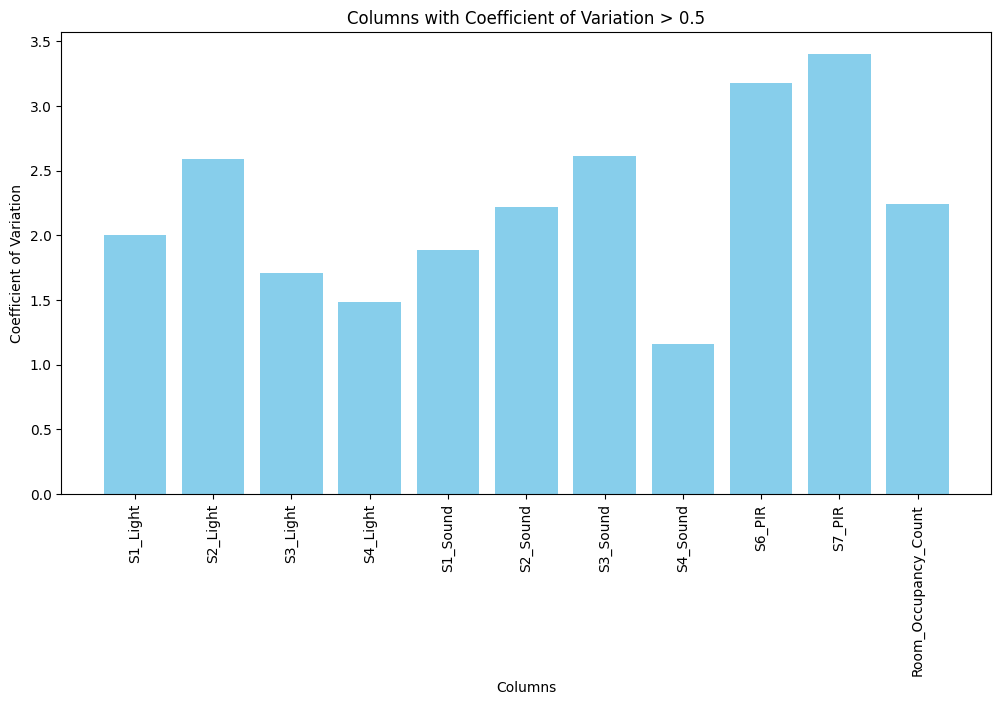

In [ ]:
# Assuming df_ is your DataFrame and has been loaded correctly
cov_values = []

# Calculating CoV for each column and storing results
for col in df_.columns:
    mean = df_[col].mean()
    std = df_[col].std()
    cov = std / mean if mean != 0 else 0  # Coefficient of Variation
    cov_values.append((col, cov))

# Filtering columns with CoV greater than 0.5
cov_above_half = [(col, cov) for col, cov in cov_values if cov > 0.5]

# Unzipping for plotting
cols, covs = zip(*cov_above_half)

# Creating the plot
plt.figure(figsize=(12, 6))
plt.bar(cols, covs, color='skyblue')
plt.title('Columns with Coefficient of Variation > 0.5')
plt.xlabel('Columns')
plt.ylabel('Coefficient of Variation')
plt.xticks(rotation=90)  # Rotate labels for better readability if needed
plt.show()

In [ ]:
print('target balance: ', df['Room_Occupancy_Count'].value_counts()/len(df))

print('PIR 1: ', df['S6_PIR'].value_counts()/len(df))
print('PIR 1: ', df['S7_PIR'].value_counts()/len(df))

target balance:  0    0.812321
2    0.073847
3    0.068516
1    0.045315
Name: Room_Occupancy_Count, dtype: float64
PIR 1:  0    0.909863
1    0.090137
Name: S6_PIR, dtype: float64
PIR 1:  0    0.920426
1    0.079574
Name: S7_PIR, dtype: float64


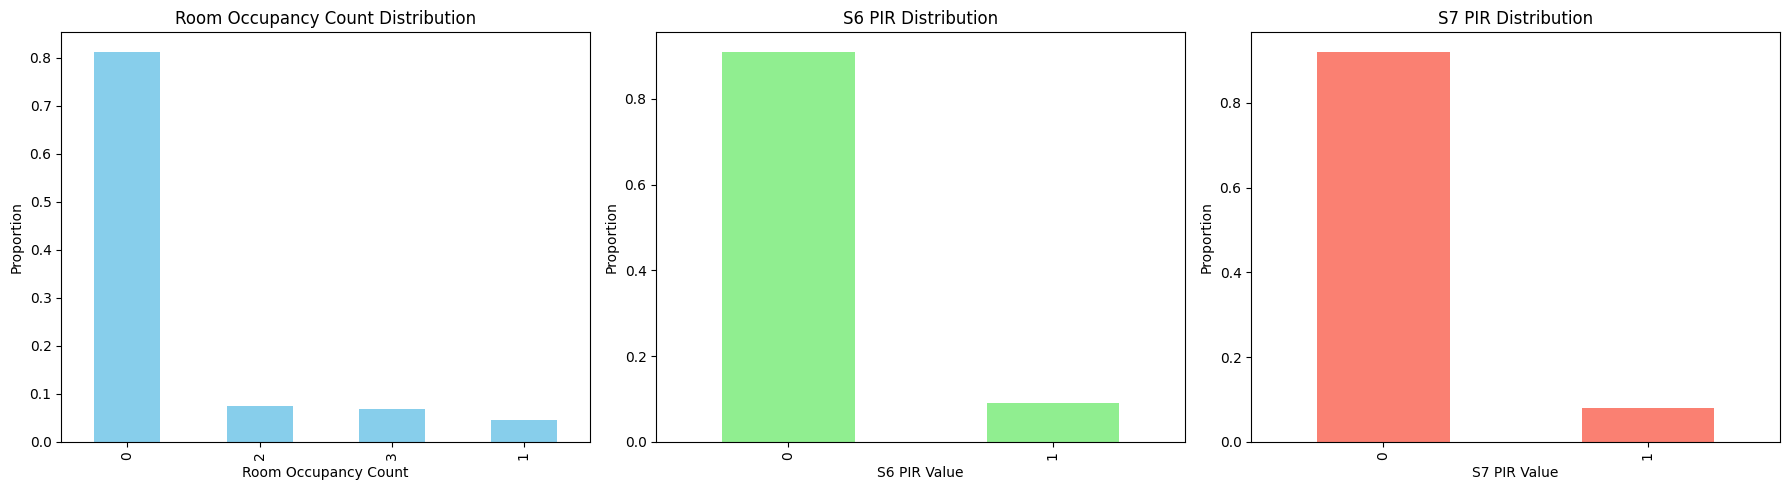

In [ ]:
# Calculate the value counts and proportions
room_occupancy_counts = df['Room_Occupancy_Count'].value_counts()/len(df)
pir_6_counts = df['S6_PIR'].value_counts()/len(df)
pir_7_counts = df['S7_PIR'].value_counts()/len(df)

# Plotting the distributions
plt.figure(figsize=(18, 5))

# Room Occupancy Counts
plt.subplot(1, 3, 1)
room_occupancy_counts.plot(kind='bar', color='skyblue')
plt.title('Room Occupancy Count Distribution')
plt.xlabel('Room Occupancy Count')
plt.ylabel('Proportion')

# PIR 6 Counts
plt.subplot(1, 3, 2)
pir_6_counts.plot(kind='bar', color='lightgreen')
plt.title('S6 PIR Distribution')
plt.xlabel('S6 PIR Value')
plt.ylabel('Proportion')

# PIR 7 Counts
plt.subplot(1, 3, 3)
pir_7_counts.plot(kind='bar', color='salmon')
plt.title('S7 PIR Distribution')
plt.xlabel('S7 PIR Value')
plt.ylabel('Proportion')

plt.tight_layout()
plt.show();


In [ ]:
df.Time

0        10:49:41
1        10:50:12
2        10:50:42
3        10:51:13
4        10:51:44
           ...   
10124    08:58:07
10125    08:58:37
10126    08:59:08
10127    08:59:39
10128    09:00:09
Name: Time, Length: 10129, dtype: object

how to combine data and time??

while time is so inconsistent??

In [6]:
df['Date'] = df['Date'].astype(str)

df['Time'] = df['Time'].astype(str)


In [7]:
# Combine 'Date' and 'Time' to a 'Datetime' column

df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


In [8]:
df['Datetime']

0       2017-12-22 10:49:41
1       2017-12-22 10:50:12
2       2017-12-22 10:50:42
3       2017-12-22 10:51:13
4       2017-12-22 10:51:44
                ...        
10124   2018-01-11 08:58:07
10125   2018-01-11 08:58:37
10126   2018-01-11 08:59:08
10127   2018-01-11 08:59:39
10128   2018-01-11 09:00:09
Name: Datetime, Length: 10129, dtype: datetime64[ns]

Then I realized that forecasting human presence does not require second precision


In [9]:
df.groupby(pd.Grouper(key='Datetime', freq='T')).sum()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
Datetime,,,,,,,,,,,,,,,,,
2017-12-22 10:49:00,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
2017-12-22 10:50:00,49.94,49.50,49.06,50.88,242,67,106,80,1.36,0.16,0.14,0.12,780,1.165385,0,0,2
2017-12-22 10:51:00,50.00,49.50,49.12,50.88,242,68,107,80,0.59,0.16,0.16,0.15,780,0.642308,0,0,2
2017-12-22 10:52:00,50.00,49.56,49.12,50.88,241,68,108,80,1.52,0.38,0.49,0.13,780,0.242308,1,0,2
2017-12-22 10:53:00,50.00,49.62,49.12,50.94,243,69,110,84,0.18,0.11,0.15,0.18,780,-0.111538,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-11 08:56:00,50.19,50.19,49.38,50.50,12,14,66,42,0.16,0.09,0.10,0.18,690,0.000000,0,0,0
2018-01-11 08:57:00,50.12,50.19,49.38,50.50,12,14,66,44,0.16,0.10,0.11,0.18,690,0.000000,0,0,0
2018-01-11 08:58:00,50.12,50.19,49.38,50.56,12,14,67,44,0.16,0.09,0.11,0.16,690,0.000000,0,0,0


In [10]:
# Resample the data to hourly means
df_resampled = df.groupby(pd.Grouper(key='Datetime', freq='T')).sum()  # 'T' for minuete

# Handle missing data if necessary
df_resampled.fillna(method='ffill', inplace=True)  # Forward fill

In [ ]:
df_resampled.isna().sum()

S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64

In [ ]:
# For discrete value columns, round to the nearest integer
import numpy as np # have no idea but if I did not do here it just says that np has no method ceil()

df_resampled['S6_PIR'] = df_resampled['S6_PIR'].apply(lambda x: np.ceil(x)).astype(int)
df_resampled['S7_PIR'] = df_resampled['S7_PIR'].apply(lambda x: np.ceil(x)).astype(int)
df_resampled['Room_Occupancy_Count'] = df_resampled['Room_Occupancy_Count'].apply(lambda x: np.ceil(x)).astype(int)

In [ ]:
df_resampled

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
Datetime,,,,,,,,,,,,,,,,,
2017-12-22 10:49:00,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
2017-12-22 10:50:00,49.94,49.50,49.06,50.88,242,67,106,80,1.36,0.16,0.14,0.12,780,1.165385,0,0,2
2017-12-22 10:51:00,50.00,49.50,49.12,50.88,242,68,107,80,0.59,0.16,0.16,0.15,780,0.642308,0,0,2
2017-12-22 10:52:00,50.00,49.56,49.12,50.88,241,68,108,80,1.52,0.38,0.49,0.13,780,0.242308,1,0,2
2017-12-22 10:53:00,50.00,49.62,49.12,50.94,243,69,110,84,0.18,0.11,0.15,0.18,780,-0.111538,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-11 08:56:00,50.19,50.19,49.38,50.50,12,14,66,42,0.16,0.09,0.10,0.18,690,0.000000,0,0,0
2018-01-11 08:57:00,50.12,50.19,49.38,50.50,12,14,66,44,0.16,0.10,0.11,0.18,690,0.000000,0,0,0
2018-01-11 08:58:00,50.12,50.19,49.38,50.56,12,14,67,44,0.16,0.09,0.11,0.16,690,0.000000,0,0,0


In [ ]:
df_resampled['Room_Occupancy_Count'].unique()

array([1, 2, 4, 0, 6, 5, 3])

Text(0, 0.5, 'the n of people')

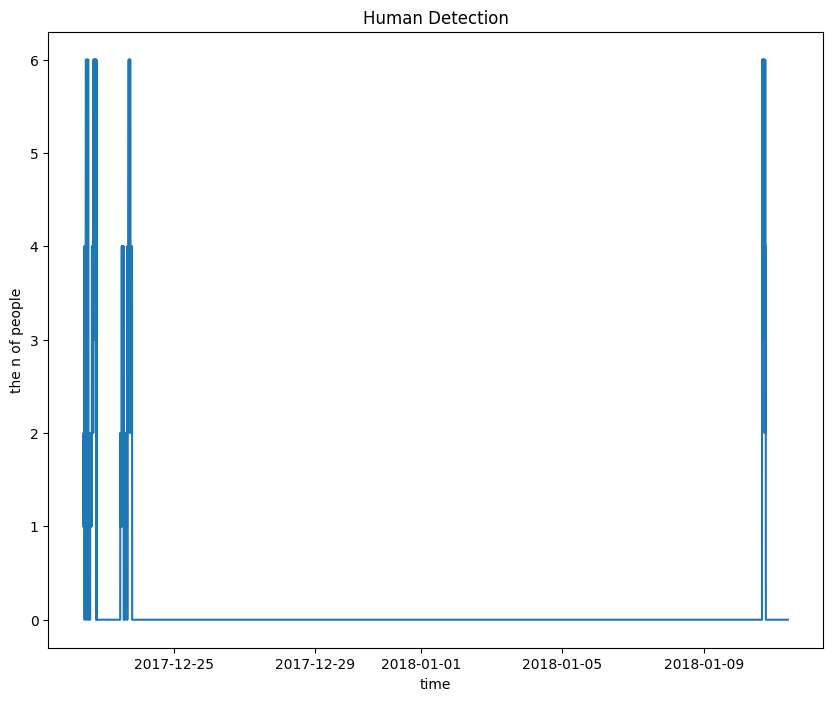

In [ ]:
plt.plot(df_resampled['Room_Occupancy_Count'])
plt.title('Human Detection')
plt.xlabel('time')
plt.ylabel('the n of people')

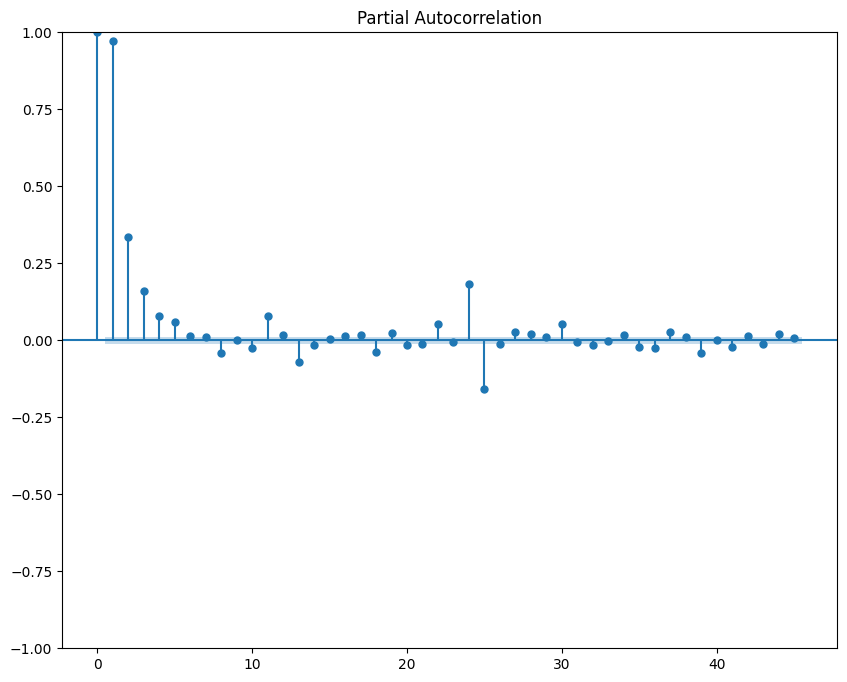

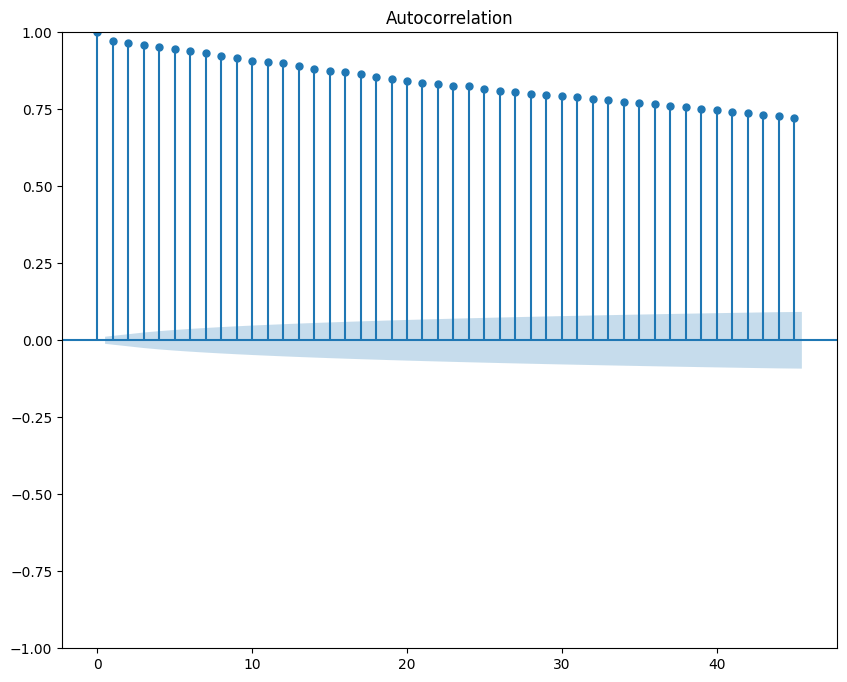

In [ ]:
plot_pacf(df_resampled['Room_Occupancy_Count']);
plot_acf(df_resampled['Room_Occupancy_Count']);

AR(2) is good start if one wants to use ARIMA

In [ ]:
pacf_ = pacf(df_resampled['Room_Occupancy_Count']);


In [ ]:
acf_ = acf(df_resampled['Room_Occupancy_Count']);


In [ ]:
for i, pacf in enumerate(pacf_):
  if pacf > .1:
    print(i, pacf)


0 1.0
1 0.9729093012370885
2 0.33564504465975153
3 0.16098730278292275
24 0.182375525023205


In [ ]:
for i, acf in enumerate(acf_):
  if acf > .2:
    print(i, acf)


0 1.0
1 0.9728753925063887
2 0.9644246634084279
3 0.9574932797212045
4 0.9506704207061765
5 0.9448785460770063
6 0.9380556870619783
7 0.9316126643996347
8 0.9231076729655763
9 0.9162848139505481
10 0.9082681835413692
11 0.9047553270283059
12 0.8989091900630374
13 0.8894817389153167
14 0.8823875682197998
15 0.8755647092047718
16 0.8694396257809993
17 0.8635392264796337
18 0.8554683337343568
19 0.8497307214412844
20 0.8422567143930831
21 0.8349454943531752
22 0.8307272274708407
23 0.8246097788250837
24 0.8266859429300908
25 0.8147081619857744
26 0.808970549692702
27 0.804589495802074
28 0.8001541795753481
29 0.7956646010125245
30 0.7929114172048296
31 0.7888016749946903
32 0.7826299640128358
33 0.77868300881099
34 0.7742476925842642
35 0.7705720490629072
36 0.7658654211556924
37 0.7609417439040868
38 0.7572042032686161
39 0.7513580663033482
40 0.7468684877405247
41 0.7420686047171458
42 0.7374315087020603
43 0.7324688386703881
44 0.7281030543357915


## adding lags

In [11]:
df_resampled['Room_Occupancy_Count_lag1'] = df_resampled['Room_Occupancy_Count'].shift(1).fillna(method='bfill')
df_resampled['Room_Occupancy_Count_lag2'] = df_resampled['Room_Occupancy_Count'].shift(2).fillna(method='bfill')
df_resampled['Room_Occupancy_Count_lag3'] = df_resampled['Room_Occupancy_Count'].shift(3).fillna(method='bfill')
df_resampled['Room_Occupancy_Count_lag24'] = df_resampled['Room_Occupancy_Count'].shift(24).fillna(method='bfill')

In [12]:
df_resampled['Room_Occupancy_Count'].shift(1).fillna(method='bfill')

Datetime
2017-12-22 10:49:00    1.0
2017-12-22 10:50:00    1.0
2017-12-22 10:51:00    2.0
2017-12-22 10:52:00    2.0
2017-12-22 10:53:00    2.0
                      ... 
2018-01-11 08:56:00    0.0
2018-01-11 08:57:00    0.0
2018-01-11 08:58:00    0.0
2018-01-11 08:59:00    0.0
2018-01-11 09:00:00    0.0
Freq: T, Name: Room_Occupancy_Count, Length: 28692, dtype: float64

In [13]:
df_resampled['Room_Occupancy_Count']

Datetime
2017-12-22 10:49:00    1
2017-12-22 10:50:00    2
2017-12-22 10:51:00    2
2017-12-22 10:52:00    2
2017-12-22 10:53:00    2
                      ..
2018-01-11 08:56:00    0
2018-01-11 08:57:00    0
2018-01-11 08:58:00    0
2018-01-11 08:59:00    0
2018-01-11 09:00:00    0
Freq: T, Name: Room_Occupancy_Count, Length: 28692, dtype: int64

In [14]:
df_resampled['Room_Occupancy_Count_lag1']

Datetime
2017-12-22 10:49:00    1.0
2017-12-22 10:50:00    1.0
2017-12-22 10:51:00    2.0
2017-12-22 10:52:00    2.0
2017-12-22 10:53:00    2.0
                      ... 
2018-01-11 08:56:00    0.0
2018-01-11 08:57:00    0.0
2018-01-11 08:58:00    0.0
2018-01-11 08:59:00    0.0
2018-01-11 09:00:00    0.0
Freq: T, Name: Room_Occupancy_Count_lag1, Length: 28692, dtype: float64

## sklearn preprocessing

In [15]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
df_resampled

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,...,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,Room_Occupancy_Count_lag1,Room_Occupancy_Count_lag2,Room_Occupancy_Count_lag3,Room_Occupancy_Count_lag24
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-12-22 10:49:00,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,...,0.06,390,0.769231,0,0,1,1.0,1.0,1.0,1.0
2017-12-22 10:50:00,49.94,49.50,49.06,50.88,242,67,106,80,1.36,0.16,...,0.12,780,1.165385,0,0,2,1.0,1.0,1.0,1.0
2017-12-22 10:51:00,50.00,49.50,49.12,50.88,242,68,107,80,0.59,0.16,...,0.15,780,0.642308,0,0,2,2.0,1.0,1.0,1.0
2017-12-22 10:52:00,50.00,49.56,49.12,50.88,241,68,108,80,1.52,0.38,...,0.13,780,0.242308,1,0,2,2.0,2.0,1.0,1.0
2017-12-22 10:53:00,50.00,49.62,49.12,50.94,243,69,110,84,0.18,0.11,...,0.18,780,-0.111538,0,0,2,2.0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-11 08:56:00,50.19,50.19,49.38,50.50,12,14,66,42,0.16,0.09,...,0.18,690,0.000000,0,0,0,0.0,0.0,0.0,0.0
2018-01-11 08:57:00,50.12,50.19,49.38,50.50,12,14,66,44,0.16,0.10,...,0.18,690,0.000000,0,0,0,0.0,0.0,0.0,0.0
2018-01-11 08:58:00,50.12,50.19,49.38,50.56,12,14,67,44,0.16,0.09,...,0.16,690,0.000000,0,0,0,0.0,0.0,0.0,0.0


In [ ]:
df_resampled.corr()['Room_Occupancy_Count'].abs()

S1_Temp                       0.384241
S2_Temp                       0.390001
S3_Temp                       0.385696
S4_Temp                       0.381801
S1_Light                      0.871763
S2_Light                      0.814229
S3_Light                      0.825482
S4_Light                      0.476928
S1_Sound                      0.713962
S2_Sound                      0.693148
S3_Sound                      0.657895
S4_Sound                      0.620419
S5_CO2                        0.602032
S5_CO2_Slope                  0.554651
S6_PIR                        0.740084
S7_PIR                        0.763686
Room_Occupancy_Count          1.000000
Room_Occupancy_Count_lag1     0.972896
Room_Occupancy_Count_lag2     0.964514
Room_Occupancy_Count_lag3     0.957651
Room_Occupancy_Count_lag24    0.828286
Name: Room_Occupancy_Count, dtype: float64

In [ ]:
df_resampled.corr().style.background_gradient(cmap='coolwarm')

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,Room_Occupancy_Count_lag1,Room_Occupancy_Count_lag2,Room_Occupancy_Count_lag3,Room_Occupancy_Count_lag24
S1_Temp,1.000000,0.999873,0.999979,0.999967,0.420979,0.338238,0.477737,0.523838,0.489497,0.427412,0.372308,0.678401,0.907650,-0.002977,0.310422,0.279932,0.384241,0.374181,0.372197,0.370808,0.365614
S2_Temp,0.999873,1.000000,0.999868,0.999833,0.426182,0.345695,0.482518,0.528987,0.493855,0.431878,0.376559,0.681880,0.909878,0.000022,0.316154,0.284557,0.390001,0.379778,0.377801,0.376385,0.370647
S3_Temp,0.999979,0.999868,1.000000,0.999961,0.421693,0.339210,0.479707,0.525886,0.489897,0.427915,0.373120,0.678984,0.908568,-0.003276,0.311408,0.281394,0.385696,0.375624,0.373649,0.372264,0.367271
S4_Temp,0.999967,0.999833,0.999961,1.000000,0.419626,0.336935,0.477001,0.526123,0.488288,0.426182,0.370745,0.677617,0.906241,-0.003436,0.308872,0.277840,0.381801,0.371778,0.369784,0.368382,0.362992
S1_Light,0.420979,0.426182,0.421693,0.419626,1.000000,0.860508,0.850161,0.611976,0.747370,0.676973,0.626212,0.624292,0.608392,0.451124,0.715290,0.621845,0.871763,0.849489,0.843458,0.837639,0.735327
S2_Light,0.338238,0.345695,0.339210,0.336935,0.860508,1.000000,0.745793,0.542389,0.633520,0.686743,0.558831,0.560108,0.528889,0.463272,0.659409,0.630155,0.814229,0.793323,0.787391,0.782379,0.696782
S3_Light,0.477737,0.482518,0.479707,0.477001,0.850161,0.745793,1.000000,0.681763,0.670611,0.594007,0.709342,0.676098,0.671414,0.391967,0.615391,0.651302,0.825482,0.804032,0.800113,0.795648,0.722579
S4_Light,0.523838,0.528987,0.525886,0.526123,0.611976,0.542389,0.681763,1.000000,0.503339,0.486784,0.342662,0.498548,0.525031,0.179227,0.453136,0.333995,0.476928,0.463554,0.459823,0.455199,0.400072
S1_Sound,0.489497,0.493855,0.489897,0.488288,0.747370,0.633520,0.670611,0.503339,1.000000,0.718631,0.680620,0.739900,0.605097,0.332302,0.673377,0.593420,0.713962,0.702281,0.697267,0.687575,0.602966
S2_Sound,0.427412,0.431878,0.427915,0.426182,0.676973,0.686743,0.594007,0.486784,0.718631,1.000000,0.645674,0.719424,0.528860,0.367952,0.637016,0.627342,0.693148,0.678478,0.666618,0.660970,0.586785


In [16]:
# Calculate correlation and select features
correlation_threshold = 0.4  # This is arbitrary; adjust based on your data exploration
correlations = df_resampled.corr()['Room_Occupancy_Count'].abs()
high_corr_features = correlations[correlations > correlation_threshold].index.tolist()

# Split the data
X = df_resampled[high_corr_features].drop('Room_Occupancy_Count', axis=1)
y = df_resampled['Room_Occupancy_Count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
# Applying SMOTE for handling imbalance
smote = SMOTE()
X_res, y_res = smote.fit_resample(X_train, y_train)


# X_res, y_res = (X_train, y_train)

In [18]:
# Using RandomForestClassifier as an example
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_res, y_res)


# Predicting and evaluating the model
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5558
           1       1.00      1.00      1.00         1
           2       0.98      1.00      0.99        48
           3       1.00      1.00      1.00         4
           4       0.97      1.00      0.99        70
           6       1.00      0.97      0.98        58

    accuracy                           1.00      5739
   macro avg       0.99      0.99      0.99      5739
weighted avg       1.00      1.00      1.00      5739



In [19]:
from joblib import dump, load

# Save the model
dump(rf, 'rf_hprf.joblib')

# Later you can load it back
# model = load('model.joblib')


['rf_hprf.joblib']

In [ ]:
# then combine xy again


In [ ]:
lgbc = lgb.LGBMClassifier(n_estimators=200)


In [ ]:
lgbc.fit(X_res, y_res)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 155029, number of used features: 16
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

LGBMClassifier(n_estimators=200)

In [ ]:
y_pred_lgb_case = lgbc.predict(X_test)
print(classification_report(y_test, y_pred_lgb_case))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5558
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00        48
           3       1.00      1.00      1.00         4
           4       0.97      1.00      0.99        70
           6       1.00      0.97      0.98        58

    accuracy                           1.00      5739
   macro avg       1.00      0.99      0.99      5739
weighted avg       1.00      1.00      1.00      5739



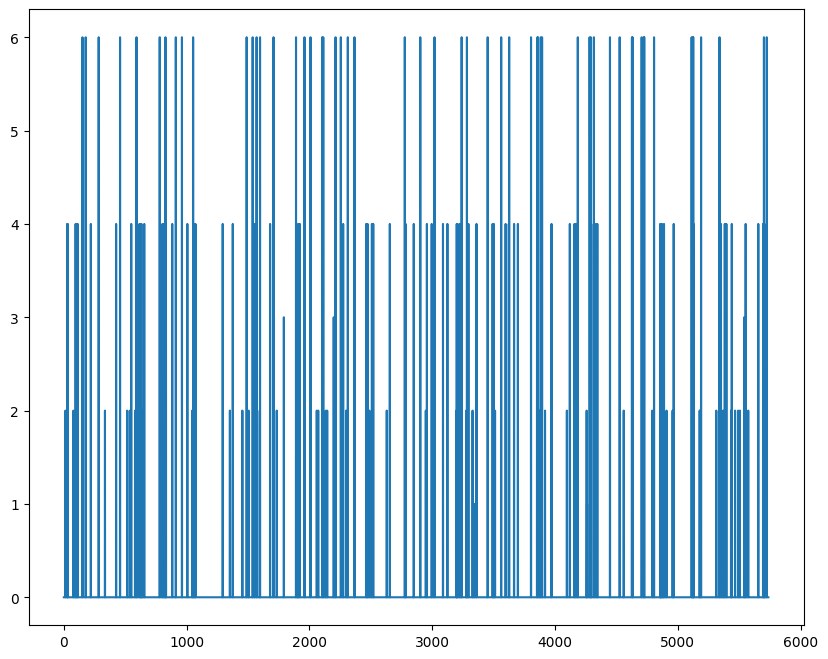

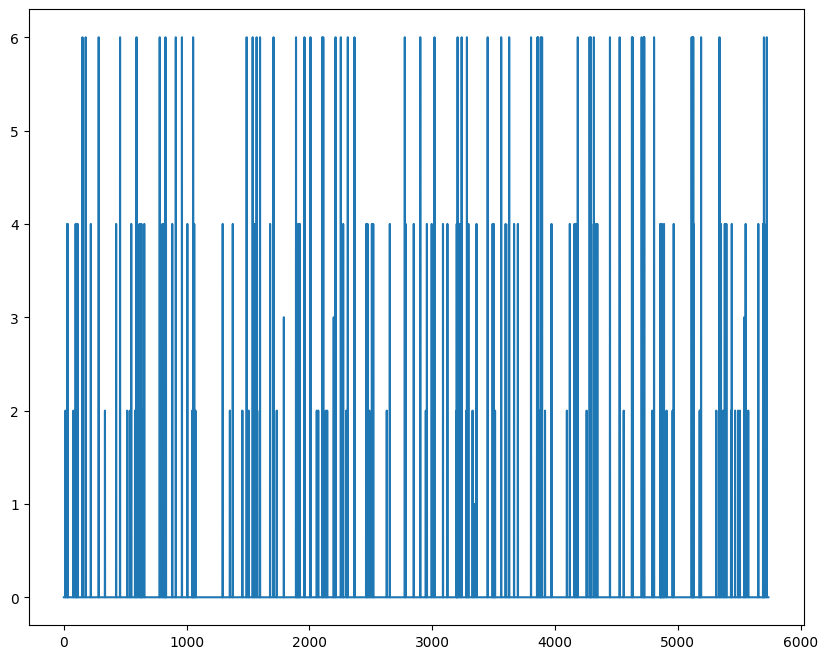

In [ ]:
plt.plot(y_pred_lgb_case);
plt.show();
plt.plot(y_pred);
plt.show();
# plt.legend(['lgbc', 'rf'])


## Voting Classifier

In [ ]:
eclf1 = VotingClassifier(estimators=[
                (
                    f"lgbc_{i}",
                    lgb.LGBMClassifier(n_estimators=200, random_state=i),
                )
                for i in range(4)
            ], voting='soft')

In [ ]:
eclf1.fit(X_res, y_res)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 155029, number of used features: 13
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

VotingClassifier(estimators=[('lgbc_0',
                              LGBMClassifier(n_estimators=200, random_state=0)),
                             ('lgbc_1',
                              LGBMClassifier(n_estimators=200, random_state=1)),
                             ('lgbc_2',
                              LGBMClassifier(n_estimators=200, random_state=2)),
                             ('lgbc_3',
                              LGBMClassifier(n_estimators=200,
                                             random_state=3))],
                 voting='soft')

In [ ]:
y_pred_eclf1_case = eclf1.predict(X_test)
print(classification_report(y_test, y_pred_eclf1_case))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5558
           1       0.50      1.00      0.67         1
           2       1.00      0.98      0.99        48
           3       1.00      1.00      1.00         4
           4       0.96      1.00      0.98        70
           6       1.00      0.97      0.98        58

    accuracy                           1.00      5739
   macro avg       0.91      0.99      0.94      5739
weighted avg       1.00      1.00      1.00      5739



In [ ]:
eclf2 = VotingClassifier(estimators=[
                (
                    f"rf_{i}",
                    RandomForestClassifier(n_estimators=200, random_state=i),
                )
                for i in range(4)
            ], voting='soft')

In [ ]:
eclf2.fit(X_res, y_res)

VotingClassifier(estimators=[('rf_0',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=0)),
                             ('rf_1',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=1)),
                             ('rf_2',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=2)),
                             ('rf_3',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=3))],
                 voting='soft')

In [ ]:
y_pred_eclf2_case = eclf2.predict(X_test)
print(classification_report(y_test, y_pred_eclf2_case))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5558
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00        48
           3       1.00      1.00      1.00         4
           4       0.97      0.99      0.98        70
           6       0.98      0.97      0.97        58

    accuracy                           1.00      5739
   macro avg       0.99      0.99      0.99      5739
weighted avg       1.00      1.00      1.00      5739



## DL approach